In [1]:
import csv
import re
import numpy as np
import pandas as pd
from pprint import pprint
import random
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
from __future__ import unicode_literals
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Setup The enviromental modules

### Import nltk

In [2]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaimemillan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words(['english','danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'portuguese', 'russian', 'spanish', 'swedish', 'turkish'])
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Get The podcast Data 

### Here we import the podcast data. At the end we will have about ~100k podcast to utilize for our prediction model. 
### This csv files offer the following information regarding the podcasts:

- podcast description from url and itunes (str)
- podcast urls (str)
- podcast explicit content (boolean)
- podcast name 
- podcast picture

## Import the files Now! 
### first create string from a- to -z so we can import them!

In [4]:
import string 
strings = string.ascii_lowercase[1:26]
print(strings)

bcdefghijklmnopqrstuvwxyz


## Import big files with podcasts

In [5]:
df = pd.read_csv("all.csv",header=None)
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

## Dictionary from numerical colums to podcast descriptions!


In [6]:
dict_num_colnames = {'slug':0,'name':1,'image_url':2,'feed_url':3,'website_url':4,
                      'itunes_owner_name':5,'itunes_owner_email':6,
                        'description':10,'itunes_summary':11}

In [7]:
dict_num_colnames = {'slug':0,'name':2,'image_url':3,'feed_url':4,'website_url':5,
                      'itunes_owner_name':6,'itunes_owner_email':7,
                        'description':11,'itunes_summary':12}

In [8]:
nbr_data =1000

## Let's Clean the podcast

### Some podcast description is misssing, or in asian languages hard to deal with. For now we will focus on English.
### Suggestion: Extend this analysis to other languages in the future

In [9]:
#backup file where we store the description, itunes_summary, name and website for each podcast
# some of this contes could be Nan, empty etc

new_df = pd.DataFrame({'content':df.iloc[:,dict_num_colnames['description']],    
                       'content2':df.iloc[:,dict_num_colnames['itunes_summary']],
                       'name': df.iloc[:,dict_num_colnames['name']],
                       'website_url': df.iloc[:,dict_num_colnames['website_url']]
                      })

## Here is where we erase asian languages

In [10]:
# Store the ids of english files (good ids list)

bad_ids= []
good_ids = []

# 
data = new_df.content[:].values.tolist()
data1 = new_df.content2[:].values.tolist()
pod_names = new_df.name[:].values.tolist()
pod_url = new_df.website_url[:].values.tolist()
#data = new_df.text[2:nbr_data].values.tolist()
new_data = []
for idx,_sentence in enumerate(data):
    
    if isinstance(_sentence,float):
        bad_ids.append(idx)
        continue
        
    tokens = _sentence.split()
    #tokens = tokens + data[idx].split()
    new_string = str()
    
    ADD_STRING = True
    for t in tokens:
        try:
            t.encode('utf-8')
            
            new_string = new_string +  t.encode('utf-8')+ ' '
            
        except:
            bad_ids.append(idx)
            ADD_STRING = False
            break
    if ADD_STRING:
        new_data.append(new_string)
        good_ids.append(idx);

### Now that we have the good files let's play with them

In [11]:
final_df =new_df.loc[:].drop(bad_ids)
data = list(new_data)
size =len(final_df);
new_index = [i for i in range(size)]
final_df.index = new_index
print("total number of podcast: " + str(len(new_data)))

total number of podcast: 92697


In [12]:
#data = new_df.content[:50].values.tolist()


# Remove Emails
new_data = []
for idx,sentence in enumerate(data):
    new_sentence=str()
    try:
        
        new_sentence =  re.sub('\S*@\S*\s?', '', sentence)
        
    except:
         continue;
            
    try:
        
        new_sentence =  re.sub('\s+', ' ', new_sentence)
        
    except:
         continue;   
    
    try:
        
        new_sentence =  re.sub("\'", "", new_sentence)
        
    except:
         continue;

    new_data.append(new_sentence)

## Note: the data list now contains the description of the podcast!

In [13]:
data = new_data
final_df.content = data
len(data)



92697

In [14]:
data[:10]

[u'10 ',
 u'A new project dedicated to all lovers of electronic music ',
 u'We chat about the movies, TV and pop-culturey stuff ',
 u'Florence Augusta Merriam Bailey was an American ornithologist and nature writer. She started observing bird behavior at a time when most bird study was based on collections and skins. By 1885, she began to write articles focusing on protecting birds. Her introduction of a birdwatching field guide, aimed at living birds, is considered the first in the tradition of modern bird guides. She wrote the first of these at the age of 26, initially as a series of notes in the Audubon Magazine and later as books. In "A-Birding on a Bronco," she writes an engaging memoir about her several trips to study birds on a ranch in California in the late 1800s. ',
 u'A radio show that plays bluegrass, old time and gospel music only by unsigned bands and discusses their playing style. ',
 u'A blend of soul,pop,funk,rhythm and blues and rock : songs by Musilosophy, singer song

## This is where we use TF-IDF and KNN to recommend podcasts based on tweeter activity

### Why TF_IDF?  Because of the following reasons:

- Is fast
- we can use all podcast
- it transform data into normalized vectors, perfect for cosine similarity

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

## Now let's use TF-IDF to:

(1) transform the data

(2) apply dot product (cosine similarity) operations for recommendation

In [16]:
from guess_language import guessLanguage

In [17]:
dict_languages = {}

for idx,sentence in enumerate(data[:1]):
    if idx % 1000 == 0:
        
        language  = guessLanguage(sentence)
    #print(language)
    try:
        val = dict_languages[language]
        val = val + 1
        dict_languages[language] = val
    except:
        dict_languages[language] = 1
        
print(dict_languages)

{'UNKNOWN': 1}


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a27409e90>],
      dtype=object)

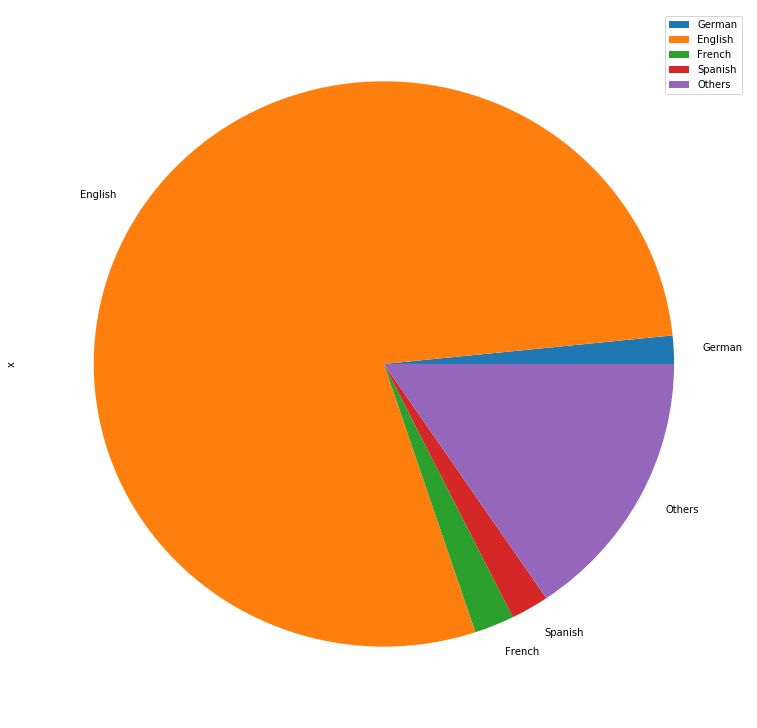

In [94]:
dict_pie = {'Others':0}
for key,val in dict_languages.items():
    if key == 'es':
        dict_pie['Spanish'] = val
        continue;
    if key == 'de':
        dict_pie['German'] = val
        continue
    if key == 'fr':
        dict_pie['French'] = val
        continue
    if key == 'en':
        dict_pie['English'] = val
        continue
    dict_pie['Others'] = dict_pie['Others'] + val
    
df = pd.DataFrame(dict_pie.values(), index=dict_pie.keys(), columns=['x'])

df.plot(kind='pie', subplots=True, figsize=(13, 13))



In [18]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



#data = [u'hello I love you more hi bye',u'hello I love you more hi bye say ', u'hello I love you more hi bye class class',u'create a python sql cpp',u'contact your mom dad son']
y = [int(1) for i in range(len(data))]

#X_test = [u'The people of Germany are turning against their leadershipas migration is rocking the already tenuous Berlin coalition. Crime in Germany is way up. Big mistake made all over Europe in allowing millions of people in who have so strongly and violently changed their culture!t!']

#X_test = ['Hey Joe,Wondering why this website: http://www.iiseagrant.org/wilmettebuoy/  and this website: http://www.ndbc.noaa.gov/station_page.php?station=45174 … show different wind dir / speed ind dir / speed ind dir / speed']
#X_test = [' Colombia animo Minutos cruciales para la democracia, votemos  Escuchemos a empresarios y trabajadores sobre la transición y prohibición del asbesto Gratitud con el Congreso de la República que acaba de aprobar el proyecto de ley por el cual se brindan condiciones para mejorar la calidad de vida del adulto mayor en Colombia']
#X_test =['Low plastic stool, cheap but delicious noodles, cold Hanoi beer.” This is how I’ll remember Tony. He taught us about food — but more importantly, about its ability to bring us together. To make us a little less afraid of the unknown. We’ll miss him.']
# Transform the training data: tfidf_train 
#X_test = ['I live in a border state. border state I appreciate the need to enforce and protect our international boundaries, but this zero-tolerance policy is cruel. It is immoral. And it breaks my heart.']

tfidf_train = tfidf_vectorizer.fit_transform(data)


#WX_test= test_tweets

# Transform the test data: tfidf_test 
#tfidf_test = tfidf_vectorizer.transform(X_test)
# Initialize a TfidfVectorizer object: tfidf_vectorizer

## Build KNN model
#modelknn = KNeighborsClassifier(n_neighbors=1)
#modelknn.fit(tfidf_train,y)

In [19]:
obamatweets = pd.read_csv('kanyewest_tweets.csv')
X = obamatweets.text.values[10:11]  
print(X)

X1  = tfidf_vectorizer.transform(X)
X = obamatweets.text.values[11:12]
X2  = tfidf_vectorizer.transform(X)
X = obamatweets.text.values[12:13]
X3  = tfidf_vectorizer.transform(X)
X = obamatweets.text.values[13:14]
X4  = tfidf_vectorizer.transform(X)
    
X_test = X1 + X2 + X3 + X4 

norm = np.sum(X_test.A**2.0)
norm = norm**0.5

X_test /= norm
tfidf_test = X_test

['\xf0\x9f\x98\xb3robots https://t.co/mgZRZWtLZp']


In [20]:
#tfidf_test = tfidf_vectorizer.transform(X_test[:10])




## Here we calculate the cosine similarity

In [19]:
# Get the cosine similarity between tweet and podcast
a= np.dot(tfidf_test,tfidf_train.T)
print("cosine sim. values : " +str(a.A))
#sort the index from closest to fartherst
a_sort = np.argsort(a.A)
print("index from closest to farthest away : "  + str(a_sort))

cosine sim. values : [[0. 0. 0. ... 0. 0. 0.]]
index from closest to farthest away : [[    0 60586 60585 ...  9636 77118 60124]]


In [20]:
a.A /= a.A.max()

In [21]:
c = np.sort(a.A.flatten())
c[len(c)-50:]

array([0.6464739 , 0.64870668, 0.65426275, 0.65533661, 0.65654927,
       0.65654927, 0.65695121, 0.65695121, 0.6577169 , 0.66598041,
       0.66874499, 0.6696999 , 0.6708883 , 0.67795553, 0.67805338,
       0.68563323, 0.7077449 , 0.71069257, 0.71133349, 0.71271551,
       0.71301773, 0.72068636, 0.72798823, 0.73727707, 0.73981097,
       0.73981097, 0.73981097, 0.74170628, 0.74170628, 0.74170628,
       0.74170628, 0.74170628, 0.74170628, 0.74170628, 0.74305119,
       0.76015134, 0.76539213, 0.7681594 , 0.79518827, 0.81719647,
       0.81719647, 0.85001344, 0.86199097, 0.88886338, 0.90512981,
       0.92066453, 0.92549186, 0.92549186, 0.94777339, 1.        ])

### Let's plot the a histogram for the cosine similarity frequency 

Text(0.5,0,u'normalized cosine similarity')

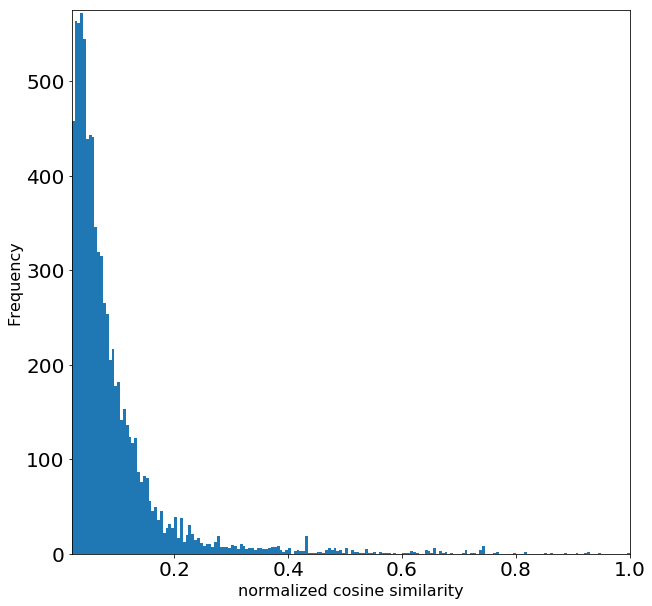

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.hist(a.A.flatten()[:], bins=200)
plt.xlim((0.02,1.0))
plt.ylim((0,575))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.ylabel('Frequency',fontsize=16)
plt.xlabel('normalized cosine similarity',fontsize=16)

Text(0.5,0,u'normalized cosine similarity')

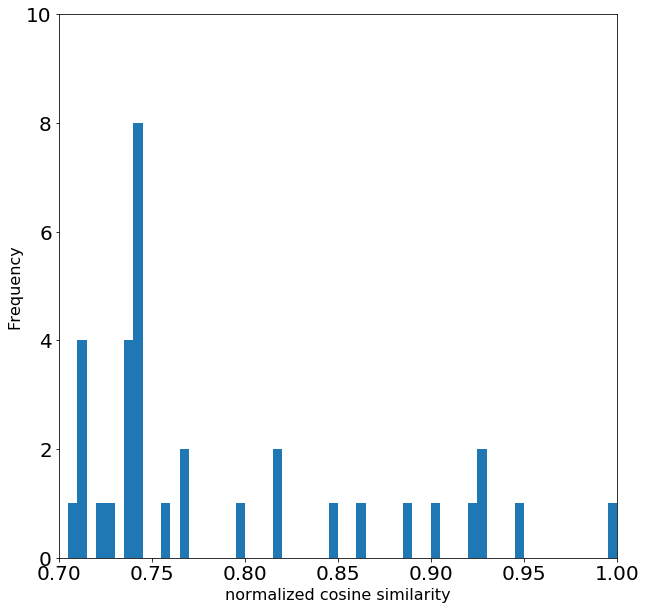

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.hist(a.A.flatten()[:], bins=200)
plt.xlim((0.7,1.0))
plt.ylim((0,10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.ylabel('Frequency',fontsize=16)
plt.xlabel('normalized cosine similarity',fontsize=16)

In [23]:
import seaborn as sn 
from scipy import stats

/Users/jaimemillan/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0.0, 0.5)

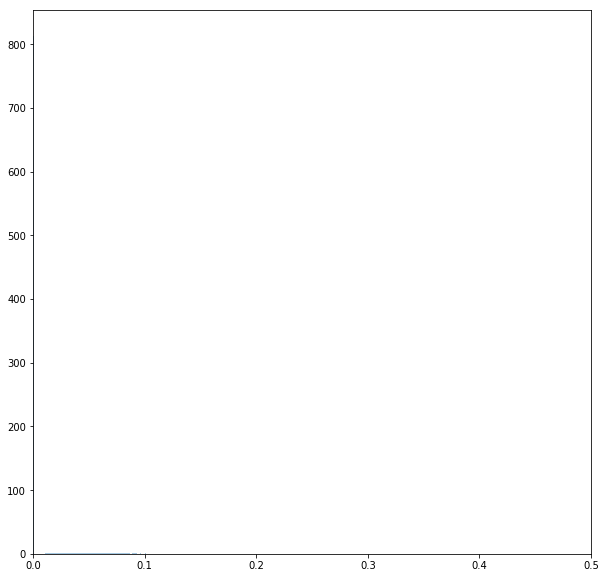

In [24]:
#sn.distplot(a.A.flatten()[:],norm_hist= True,bins=60 )
#sn.kdeplot(a.A.flatten()[:])
sn.distplot(a.A.flatten()[:],kde=False,norm_hist=True,bins=900)
#sn.distplot(a.A.flatten()[:], hist=False);
plt.xlim((0.,0.5))

In [ ]:
plt.hist(a.A.flatten()[:], bins=25)
plt.xlim((0.645,1.0))
plt.ylim((0,50))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.ylabel('Frequency',fontsize=16)
plt.xlabel('normalized cosine similarity',fontsize=16)

In [25]:
np.savetxt('similarity_score.dat',a.A.flatten()[:])

In [43]:
df_cos = np.genfromtxt('out.dat')

Text(0.5,0,u'normalized cosine similarity')

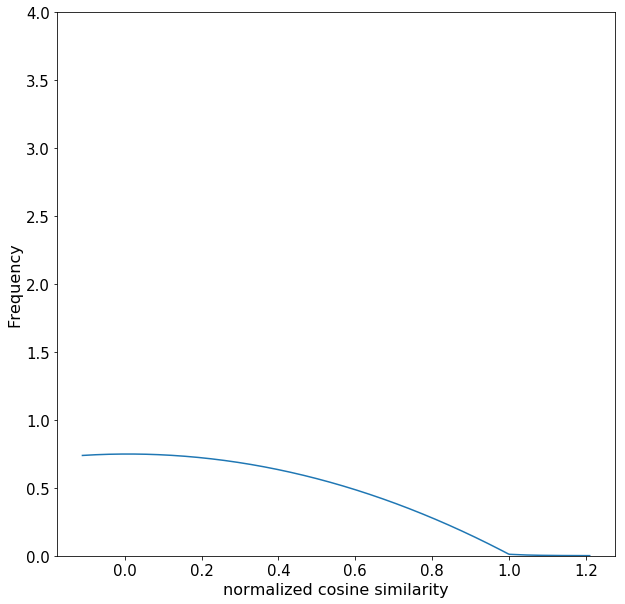

In [44]:

rcParams['figure.figsize'] = 10, 10
plt.plot(df_cos[:,0], df_cos[:,1])
#plt.xlim((0.02,1.0))
plt.ylim((0,4))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.ylabel('Frequency',fontsize=16)
plt.xlabel('normalized cosine similarity',fontsize=16)

In [24]:
a.A.flatten().shape

(92697,)

### Let's get the first 100 closest podcasts!

In [25]:
max_vals_idx =  a_sort.flatten()[::-1][:100]

In [41]:
tt,t1 = get_user_tweets("viewtifuljimmy")

In [44]:
t1

[[u'1019624629994971138',
  datetime.datetime(2018, 7, 18, 16, 47, 10),
  '@PFather101 test'],
 [u'987083469535764481',
  datetime.datetime(2018, 4, 19, 21, 40, 12),
  '@lindiortega Thank you so much for braving the snowstorm to come play in Minnesota last week.  I was so happy I fin\xe2\x80\xa6 https://t.co/26r0BA1uz3'],
 [u'963844387527626752',
  datetime.datetime(2018, 2, 14, 18, 36, 24),
  '@MoviePass_CS I have been waiting for over a month to hear back on the support ticket that I opened.  Ticket number\xe2\x80\xa6 https://t.co/8sJMBLVUqE'],
 [u'805916329341493248',
  datetime.datetime(2016, 12, 5, 23, 26, 40),
  "@lindiortega I'd love to hear you cover Hurt by Nine Inch Nails"],
 [u'784398198940897280',
  datetime.datetime(2016, 10, 7, 14, 21, 18),
  "@pennjillette Now's your chance to go bright pink! You've already bleached your hair so you're half way there! https://t.co/fUIRrDnyN9"],
 [u'778685297999564804',
  datetime.datetime(2016, 9, 21, 20, 0, 16),
  'My Insight blog post 

In [29]:

def get_from_tfidf(user ='kanyewest'):
    user_tweets = pd.read_csv(user + '_tweets.csv')
    user_tweets = user_tweets.text.values[:10]
    
   
    all_X_test = tfidf_vectorizer.transform(user_tweets)
    
    weights = range(1,len(all_X_test.A));
    weights = sorted(weights,reverse=True)
    

    X_test = tfidf_vectorizer.transform(user_tweets)
    final_vect = X_test[0]
    
    podcast_descriptions = []
    final_urls = []
    
    
    for idx,vec_X in enumerate(X_test[:]):
        
    
       # weight = weights[idx]

        final_vect = vec_X + final_vect
    
        a= np.dot(vec_X,tfidf_train.T)
        a_sort = np.argsort(a.A)
        max_vals_idx =  a_sort.flatten()[::-1][:10]
        
        
        for idx in max_vals_idx:
            podcast_descriptions.append(data[idx])
          
        urls  = final_df.loc[max_vals_idx].website_url.values.tolist()
        final_urls = final_urls + random.sample(urls,5)
        
    
    return random.sample(final_urls,3),podcast_descriptions , max_vals_idx;

    #norm = np.sum(final_vect.A**2.0)
    #norm = norm**0.5

    #final_vect /= norm
    #tfidf_test = final_vect
    
    ## Get the cosine similarity between tweet and podcast
    #a= np.dot(tfidf_test,tfidf_train.T)
    ##print("cosine sim. values : " +str(a.A))
    ##sort the index from closest to fartherst
    #a_sort = np.argsort(a.A)
    ##print("index from closest to farthest away : "  + str(a_sort))
    
    #max_vals_idx =  a_sort.flatten()[::-1][:100]
    #podcast_descriptions = []
    #for idx in max_vals_idx:
    #    podcast_descriptions.append(data[idx]) 

    ##print(podcast_descriptions[:10])
    #urls  = final_df.loc[max_vals_idx].website_url.values.tolist()
    #final_urls = random.sample(urls,3)
    #return final_urls,podcast_descriptions , max_vals_idx;


tfidf_urls, podcast_descriptions, max_vals_idx = get_from_tfidf('BarackObama')




In [30]:
podcast_descriptions

[u'Define yourself. ',
 u'We Define Expression! ',
 u'We Define Expression! ',
 u'Booka Shade latest Mix ',
 u'Have your own experience ',
 u'Voice Of The People ',
 u'History in a Podcast ',
 u'History Podcast ',
 u'A podcast on history. ',
 u'The voice of your community ',
 u'Same Idea, But Better! ',
 u'Every week on Will and Bobby Know Everything, hosts Will and Bobby learn more about each other and the world around them. And find both lacking! Listen to WBKE every week to hear the funniest, weirdest, and most absurd conversation available anywhere on the internet! Follow Will and Bobby on Twitter: and Will and Bobby Know Everything is a proud member of the WB2045 Podcast Network, available at WB2045.com! ',
 u'Music and Videos by Cameron Kennedy ',
 u'Comedians Bobby and Nick host their very own podcast! ',
 u'Acting, Voice, Photo ',
 u'Lessons From the Heroes of Faith ',
 u'Lessons From the Heroes of Faith ',
 u'We have no idea what we&#039;re talking about ',
 u'Acting without t

### Let's look at the URLs!

In [22]:
t = final_df.loc[max_vals_idx]
t.website_url[:20]

65726    http://soundcloud.com/power-violence-podcast
84124               http://www.moviespoofmaddness.com
35191                   http://frontsight.podbean.com
50018               http://libertyshock.podomatic.com
84126                http://topgunradio.blogspot.com/
39049            http://www.blogtalkradio.com/gunnuts
22011               http://www.canadianreloadradio.ca
39048                          http://www.gunnews.com
39046                      http://www.gunguyradio.com
52668                          http://marcstevens.net
Name: website_url, dtype: object

### Let's look at the Podcasts Descriptions!

In [23]:
podcast_descriptions = []
for idx in max_vals_idx:
    podcast_descriptions.append(data[idx]) 

podcast_descriptions[:20]

[u'Podcast by Power Violence Podcast ',
 u'Top Gun like you never seen before. ',
 u'Gun News and Commentary, firearms, guns, Gun rights, gun law, self defense, RKBA, Second Amendment ',
 u'Helping people see the gun in the room. ',
 u'Home of the Top Gun Radio podcast. Find us on iTunes today! ',
 u'Gun Nuts Radio is a pro-gun, political radio show hosted by Caleb from Gun Nuts Media and various guest hosts. Each week, well discuss issues important to the shooting community, from politics to new guns and gear. ',
 u'Canadian Pro-Gun Internet Radio ',
 u'Gun News--News by The Barrel ',
 u'Positive &amp; politics free gun podcast hosted by Jake Challand. We discuss guns, gun rights, shooting, and the firearm industry. ',
 u'No product or service should be provided at the barrel of a gun ']

100

In [222]:

Xtr = tfidf_vectorizer.transform(podcast_descriptions)
features = tfidf_vectorizer.get_feature_names()


In [26]:
def top_tfidf_feats(row, features, top_n=25):
    
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df
def top_feats_in_doc(Xtr, features, row_id, top_n=25):

    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [28]:
Xtr = tfidf_vectorizer.transform(podcast_descriptions)
features = tfidf_vectorizer.get_feature_names()

buzz_words = []
for i in range(len(podcast_descriptions)):
    a = top_feats_in_doc(Xtr, features, row_id=i, top_n=100)
    word = a.feature.values.tolist()[0]
    
    buzz_words.append(word)

final_string = set(buzz_words)
buzz_words = list(final_string)
final_string = random.choice(buzz_words)
for i in range(4):
    
    trial_word = random.choice(buzz_words)
    final_string = final_string + "+" + trial_word

#signal_string = final_string[0] + "+" +final_string[1]+ "+" + final_string[2] + "+"+ final_string[3]
final_string

u'barrel+gun+gun+violence+gun'

In [24]:
import unirest

In [31]:
def get_from_listen_notes(descriptions):
    Xtr = tfidf_vectorizer.transform(descriptions)
    features = tfidf_vectorizer.get_feature_names()

    buzz_words = []
    for i in range(30):
        a = top_feats_in_doc(Xtr, features, row_id=i, top_n=50)
        word = a.feature.values.tolist()[0]
        buzz_words.append(word)
        
    final_string = set(buzz_words)
    buzz_words = list(final_string)
    final_string = random.choice(buzz_words)
    for i in range(1):

        trial_word = random.choice(buzz_words)
        final_string = final_string + "+" + trial_word
    
    response = unirest.get("https://listennotes.p.mashape.com/api/v1/search?genre_ids=68%2C100&language=English&len_max=60&len_min=2&offset=0&only_in=Only+search+in+these+fields&published_after=1390190241000&published_before=1490190241000&q=" + final_string + "&sort_by_date=0&type=episode",
      headers={
        "X-Mashape-Key": "",
        "Accept": "application/json"
      }
    )

    listen_notes_pods = response.body['results']


    response_listen_notes=[]
    if len(listen_notes_pods)> 0:
        rand_pod = random.choice(listen_notes_pods)
        response_listen_notes.append(rand_pod[u'audio'])

    return response_listen_notes

a = get_from_listen_notes(podcast_descriptions)

if len(a) > 0:
    test_msg = 'user ' + a[0]
    print(test_msg)
    
else:
    print('empty suggestion')
    print(a)

user https://www.listennotes.com/e/p/4ac781111ea246309037747f3c223912/


In [32]:
def split_hashtag(hashtagestring):
    fo = re.compile(r'#[A-Z]{2,}(?![a-z])|[A-Z][a-z]+')
    fi = fo.findall(hashtagestring)
    result = ''
    for var in fi:
        result += var + ' '
        #print (result)
    result = result.split()
    return result;


    
    

In [34]:
def listen_notes_favorite(n='All'):
    # These code snippets use an open-source library. http://unirest.io/python
    response = unirest.get("https://listennotes.p.mashape.com/api/v1/best_podcasts?page=1",
              headers={
        "X-Mashape-Key": "",
    "Accept": "application/json"
        }
    )

    listen_notes_pods = response.body['channels']
   # print(listen_notes_pods[1]['website'])
    response_listen_notes=[]
    if len(listen_notes_pods) > 5:

        for i in range(3):
            response_listen_notes.append(listen_notes_pods[i][u'website'])

    else:

        for i in range(len(listen_notes_pods)):
            response_listen_notes.append(listen_notes_pods[i][u'website'])

    url_string = str();
    if n == 'All' or n == 0:
        
        for i in response_listen_notes:
            url_string = url_string + " " + str(i)
            
    else:
        for i in range(n):
            _url = response_listen_notes[i]
            url_string = url_string + " " + str(_url)
    
    return url_string

test_favorite = listen_notes_favorite()


if len(test_favorite) > 0:
    test_msg = 'user ' + test_favorite
    print(test_msg)
    
else:
    print('empty suggestion')
    print(a)

user  https://art19.com/shows/spit?utm_source=listennotes.com&utm_campaign=Listen+Notes&utm_medium=website http://www.espn.com/espnradio/podcast/index?utm_source=listennotes.com&utm_campaign=Listen+Notes&utm_medium=website https://www.wordsmattermedia.com/?utm_source=listennotes.com&utm_campaign=Listen+Notes&utm_medium=website


In [35]:
def get_from_hashtag(all_hashtags):
    all_bi_tokens = []
    for h_tag in all_hashtags:
        
        trial_bitoken = split_hashtag(h_tag)
       # print(trial_bitoken)
        if len(trial_bitoken) > 1:
            all_bi_tokens.append(trial_bitoken)
    
    
    HASHTAG_BAD = True
    while HASHTAG_BAD:
        hash_signal = random.choice(all_bi_tokens)
        final_hash_signal = hash_signal[0]
        h_tag_user = "@" + hash_signal[0]
        check_hash = hash_signal[0]
        
        for i in range(1,len(hash_signal)):
            
            final_hash_signal = final_hash_signal + "+" + hash_signal[i]
            h_tag_user = h_tag_user + hash_signal[i]
            check_hash = check_hash + hash_signal[i]
        
        
        
        if check_hash in all_hashtags:
            
            HASHTAG_BAD = False;
            
        else:
            
            
            
            return [],None,None

    
    
    Celebrity = True;
    while Celebrity:
            
        
        try:
            
            user = api.get_user(h_tag_user)
            
        
        except tweepy.error.TweepError as e:
            time.sleep(180)
            user = api.get_user(h_tag_user)
        try:
            
            nbr_friends = user.followers_count
            
            
            
        except tweepy.error.TweepError as e:
            time.sleep(180)
            nbr_friends = user.followers_count
            
        if nbr_friends < 1000000:
            Celebrity = False;
            return [],None,None
            
        else:
            Celebrity = False
            
    
    response = unirest.get("https://listennotes.p.mashape.com/api/v1/search?genre_ids=68%2C110&language=English&len_max=50&len_min=2&offset=0&only_in=Only+search+in+these+fields&published_after=1390190241000&published_before=1490190241000&q=" + final_hash_signal + "&sort_by_date=0&type=episode",
    headers={
    "X-Mashape-Key": "",
    "Accept": "application/json"
              }
            )

    listen_notes_pods = response.body['results']


    response_listen_notes=[]
    if len(listen_notes_pods)> 0:
        rand_pod = random.choice(listen_notes_pods)
      #  print(rand_pod)
        response_listen_notes.append(rand_pod[u'audio'])
        
        
    return response_listen_notes, h_tag_user,final_hash_signal

#print(a)

test_friends,test_twitter = get_user_tweets('BarackObama')
test_url_hashtag,b,c = get_from_hashtag(test_friends[:2] + [u'BarackObama'])

if len(test_url_hashtag) > 0:
    test_msg = 'user ' + test_url_hashtag[0]
    print(test_msg)
    
else:
    print('empty suggestion')

NameError: name 'get_user_tweets' is not defined

In [40]:
def get_from_hashtag_test(all_hashtags):
    all_bi_tokens = []
    for h_tag in all_hashtags:
        
        trial_bitoken = split_hashtag(h_tag)
       # print(trial_bitoken)
        if len(trial_bitoken) > 1:
            all_bi_tokens.append(trial_bitoken)
    
    print(all_bi_tokens)
    if len(all_bi_tokens) > 0:
        random.shuffle(all_bi_tokens)
        
    else:
        return [],None,None
    
    
    
    
    for i in range(len(all_bi_tokens)):
        
        
        hash_signal = all_bi_tokens[i]
        final_hash_signal = hash_signal[0]
        h_tag_user = "@" + hash_signal[0]
        check_hash = hash_signal[0]
        
        for j in range(1,len(hash_signal)):
            
            final_hash_signal = final_hash_signal + "+" + hash_signal[j]
            h_tag_user = h_tag_user + hash_signal[j]
            check_hash = check_hash + hash_signal[j]
        
        
        print(check_hash)
        if check_hash in all_hashtags:
            
            
            try:
            
                user = api.get_user(h_tag_user)


            except tweepy.error.TweepError as e:
                time.sleep(180)
                user = api.get_user(h_tag_user)
            try:

                nbr_friends = user.followers_count



            except tweepy.error.TweepError as e:
                time.sleep(180)
                nbr_friends = user.followers_count

            if nbr_friends < 3000:
                print('not celebrity')
                continue;

            else:
                print(final_hash_signal)
                response = unirest.get("https://listennotes.p.mashape.com/api/v1/search?genre_ids=68%2C110&language=English&len_max=50&len_min=2&offset=0&only_in=Only+search+in+these+fields&published_after=1390190241000&published_before=1490190241000&q=" + final_hash_signal + "&sort_by_date=0&type=episode",
                            headers={
                            "X-Mashape-Key": "",
                            "Accept": "application/json"
                                      }
                                    )

                listen_notes_pods = response.body['results']


                response_listen_notes=[]
                if len(listen_notes_pods)> 0:
                    print('found')
                    rand_pod = random.choice(listen_notes_pods)
                  #  print(rand_pod)
                    response_listen_notes.append(rand_pod[u'audio'])
                    return response_listen_notes, h_tag_user,final_hash_signal
                else:
                    continue
                 
                 
            
               
        else:
            
            continue;

    
       
    return [],None,None

    
    
    
            
    
    

#print(a)

test_friends,test_twitter = get_user_tweets('CodyJSchank')
#print(test_friends)
test_url_hashtag,b,c = get_from_hashtag_test(test_friends[:])

#test_url_hashtag,b,c = get_from_hashtag_test( ['jandresmillan','IamRoot'])




if len(test_url_hashtag) > 0:
    test_msg = 'user ' + test_url_hashtag[0]
    print(test_msg)
    
else:
    print('empty suggestion')

[[u'Jason', u'Isbell'], [u'Danielle', u'All'], [u'Julie', u'Students'], [u'Blue', u'Action', u'Dems'], [u'Sean', u'Mc', u'Elwee'], [u'Michelle', u'Obama'], [u'Steve', u'Kerr'], [u'Adr', u'Bell']]
JasonIsbell
Jason+Isbell
found
user https://www.listennotes.com/e/p/77afb7f0787947c7bce23527f6c06082/


In [60]:
split_hashtag('SpencerTexas')

[u'Spencer', u'Texas']

In [37]:
import tweepy
import random
#from our keys module (keys.py), import the keys dictionary

CONSUMER_KEY = ""
CONSUMER_SECRET = ""
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""




auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [38]:
import itunes
import unirest
import tweet_dumper
import time

In [39]:
def get_user_tweets(screen_name):
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    try:
        user = api.get_user(screen_name)
    except tweepy.error.TweepError as e:
        time.sleep(180)
        user = api.get_user(screen_name)
    try:
        friends = user.friends()
        
    except tweepy.error.TweepError as e:
        time.sleep(180)
        friends = user.friends()
    #print(user.screen_name)
    all_friends = []
    for friend in friends:
        all_friends.append(friend.screen_name)
    
    alltweets = []
    if len(new_tweets) < 1:
        
        return friends,[]
    #save most recent tweets
    
   
    
    
    alltweets.extend(new_tweets)

    #save the id of the oldest tweet less one

    if len(new_tweets) > 0:
        
        oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) < 0:
        #print "getting tweets before %s" % (oldest)

    #all subsiquent requests use the max_id param to prevent duplicates
        try:
            new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
                
        except tweepy.error.TweepError as e:
            time.sleep(180)
            new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
            
            
    #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        #print(oldest)

        #print "...%s tweets downloaded so far" % (len(alltweets))

        #transform the tweepy tweets into a 2D array that will populate the csv 
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]
    with open('%s_tweets.csv' % screen_name, 'wb') as f:
        writer = csv.writer(f)
       # print("writting")
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)
    
    return all_friends,outtweets
try:
    a,b =get_user_tweets('BarackObama')

except tweepy.error.TweepError as e:
    print('going to sleep')
    time.sleep(15*60)
    a,b = get_user_tweets('BarackObama')

##  BOT MAIN BODY
## BOT MAIN BODY


In [228]:
#Get history of tweets 
#
final_name = str()
try:
    public_tweets = api.mentions_timeline()
except tweepy.error.TweepError as e:
    time.sleep(180)
    public_tweets = api.mentions_timeline()
    
print(len(public_tweets))
#look at first tweet only for now



#loop_idx = 0
for i in range(1):
    
    for idx,tweet in enumerate(public_tweets):
       
        #print("found tweet :" + str(idx))
        print(tweet.text)
        #break on other tweets
        if idx >0:
            break;

        #split tweet to get username
        try:
            buffer_str =str(tweet.text).split()
        except tweepy.error.TweepError as e:
            time.sleep(180)
            buffer_str =str(tweet.text).split()
            
        #get into first tweet
        if idx == 0 :
                
                #user info
                sn = str()
                try:
                    #user = api.get_user(tweet.id)
                    #user screen name
                    sn = tweet.user.screen_name
                except tweepy.error.TweepError as e:
                    time.sleep(180)
                    
                    #user screen name
                    sn = tweet.user.screen_name
                print(sn)
                
                final_name = sn
                my_file = open('last_user.dat','w')
                my_file.write(final_name + " " + str(tweet.created_at))
                my_file.close()
print(final_name)



20
@PFather101 hello hello
jandresmillan
@PFather101 test test
jandresmillan


In [ ]:
my_file = open('last_user.dat','r')
last_user_info = my_file.readline()
last_user_info = last_user_info.split();
final_name = last_user_info[0]
time_final_name = last_user_info[1]
time_final_name= pd.Timestamp(time_final_name)
print(type(time_final_name))
time_final_name = time_final_name.to_pydatetime()
print(time_final_name.second)
my_file.close()

In [6]:
import pandas as pd 

In [25]:
a='2015-05-02 12:06:41'
b ='2015-05-01 12:06:41'


In [204]:
Epsilon = 1e-9;
def different_timestamp(_stamp1,_stamp2):
    stamp1= pd.Timestamp(_stamp1)
    stamp1 = stamp1.to_pydatetime()
 
    stamp2 = pd.Timestamp(_stamp2)
    stamp2 = stamp2.to_pydatetime()
   
    
    if abs(stamp1.year - stamp2.year) > 1e-9:
            return True;
    if abs(stamp1.month - stamp2.month) > 1e-9:
            return True;
    if abs(stamp1.day - stamp2.day) > 1e-9:
            return True;
        
    if abs(stamp1.hour - stamp2.hour) > 1e-9:
            return True;
    
    if abs(stamp1.second - stamp2.second) > 1e-9:
            return True;
    
    return False

In [205]:

def get_last_user(filename='last_user.dat'):
    my_file = open(filename,'r')
    line = my_file.readline()
    user_info =line.split()
    my_file.close()
    
    return user_info[0],user_info[1] + " " + user_info[2]

finalname,finalstamp = get_last_user()

different_timestamp(finalstamp,finalstamp)

False

In [31]:
different_timestamp(a,b)

2015-05-02 12:06:41
2015-05-01 12:06:41


True

In [226]:
sn ='BarackObama'

try:
    all_friends,all_tweets = get_user_tweets(sn)
except tweepy.error.TweepError as e:
    time.sleep(180)
    all_friends,all_tweets = get_user_tweets(sn)


tfidf_urls, podcast_descriptions, max_vals_idx = get_from_tfidf(sn)
favorite_podcast_url = listen_notes_favorite() 


url_hashtag,hashtags,signal_hashtags = get_from_hashtag(all_friends)
buzzwords_urls = get_from_listen_notes(podcast_descriptions)
podcast_recommendations = str()
podcast_recommendations_list = []


if len(url_hashtag) > 0:
    
    podcast_recommendations = url_hashtag[0] + " " + podcast_recommendations
    podcast_recommendations_list.append(url_hashtag[0]);

else:
    
    podcast_recommendations = listen_notes_favorite(1) + " " + podcast_recommendations
    
if len(tfidf_urls) > 0:
    
    for _podcast in tfidf_urls:
        podcast_recommendations = _podcast + " " + podcast_recommendations
        podcast_recommendations_list.append(_podcast)

else:
    
    podcast_recommendations = listen_notes_favorite(3) + " " + podcast_recommendations

if len(buzzwords_urls) >0:
    
    podcast_recommendations = buzzwords_urls[0] + " " + podcast_recommendations
    podcast_recommendations_list.append(buzzwords_urls[0]);

else:
    
    podcast_recommendations = listen_notes_favorite(1) + " " + podcast_recommendations

if len(podcast_recommendations_list) > 0:
    m = "@" + sn + " listen "  + podcast_recommendations
    
    print(m)
else:
    favorite_urls = listen_notes_favorite()
    m = "@" + sn + " listen "  + favorite_urls
    
    print(m)




@BarackObama listen https://www.listennotes.com/e/p/f516221134734e979490142df01712a0/ http://thetruthcast.podomatic.com http://citygatechurch.co.uk http://platformbiased.com  https://www.americanmediainc.com/?utm_source=listennotes.com&utm_campaign=Listen+Notes&utm_medium=website 


In [230]:
#final_name = 'yo'


stop_name = str()
#loop through twwets in timeline
for i in range(100):
    if i%5==0:
        
        print("loop: " + str(i))
    
    try:
        public_tweets = api.mentions_timeline()
    except tweepy.error.TweepError as e:
        
        time.sleep(5*60)
        public_tweets = api.mentions_timeline()
        
    final_name,finalstamp = get_last_user()
    print("finalname " + str(final_name) + " finalstamp " + " " + str(finalstamp) )
    for idx,tweet in enumerate(public_tweets):
       
        #print("found tweet :" + str(idx))
      #  print(tweet.text)
        #break on other tweets
        

        #split tweet to get username
        try:
            buffer_str =str(tweet.text).split()
        except tweepy.error.TweepError as e:
            time.sleep(180)
            buffer_str =str(tweet.text).split()

        #get into first tweet
        
        if idx ==0:
            sn = str()
            try:
                #user = api.get_user(tweet.id)
                #user screen name
                sn = tweet.user.screen_name
                my_file = open('last_user.dat','w')
                my_file.write(sn + " " + str(tweet.created_at))
                my_file.close()
            except tweepy.error.TweepError as e:
                time.sleep(180)
                #user screen name
                sn = tweet.user.screen_name
                my_file = open('last_user.dat','w')
                my_file.write(sn + " " + str(tweet.created_at))
                my_file.flush()
                my_file.close()
            
             
            
                
        if idx >=0:
                
                    
                
                #user info
                #Get name
                sn = str()
                try:
                    #user = api.get_user(tweet.id)
                    #user screen name
                    sn = tweet.user.screen_name
                except tweepy.error.TweepError as e:
                    time.sleep(180)
                    
                    #user screen name
                    sn = tweet.user.screen_name
               # print(sn)
                
                #Get tweet info to check if it is a new tweet or an old one
                timestamp_tweet = tweet.created_at
                timestamp_tweet = pd.Timestamp(timestamp_tweet)
                timestamp_tweet = timestamp_tweet.to_pydatetime()
                
                check_stamp= different_timestamp(timestamp_tweet,finalstamp)
                
                #Check if it is the last user from last batch
                if sn == final_name and not check_stamp:
                    print("username " + str(sn) + " userstamp " + " " + str(timestamp_tweet) )
                   # print('here')
                    time.sleep(5);
                    break;
                    
                #new tweet, send reply to user
                else:
                   
                #get tweet, and friends from user
                    try:
                        all_friends,all_tweets = get_user_tweets(sn)
                    except tweepy.error.TweepError as e:
                        time.sleep(180)
                        all_friends,all_tweets = get_user_tweets(sn)

                    
                    # Too few Twitter activity by user
                    # send most popular
                    if sn != "PFather101" and len(all_tweets) < 5:
                        try:
                            print("most popular")
                           
                            podcast_recommendations = listen_notes_favorite(3) 
                            m = "@" + sn + " listen "  + podcast_recommendations
                            s = api.update_status(m, tweet.id)
                            break;

                        except tweepy.error.TweepError as e:
                            print("most popular")
                            time.sleep(180)
                            podcast_recommendations = str()
                            podcast_recommendations = listen_notes_favorite(3) + " " + podcast_recommendations
                            m = "@" + sn + " listen "  + podcast_recommendations
                            s = api.update_status(m, tweet.id)
                            break;
                    
                    
                    
                    ####In the following we try get podcast recommendation based on who Twitter posting, following, buzz words
                    
                    #Use tdidf to get podcasts basse on what they post
                    tfidf_urls, podcast_descriptions, max_vals_idx = get_from_tfidf(sn)
                    favorite_podcast_url = listen_notes_favorite() 

                    
                    
                    #get podcasts basse on who they follow
                    url_hashtag,hashtags,signal_hashtags = get_from_hashtag(all_friends)
                    #get podcast based on buzz words
                    
                    buzzwords_urls = get_from_listen_notes(podcast_descriptions)
                    
                    
                    #now create twittere message to user based on the podcast we obtained
                    podcast_recommendations = str()
                    podcast_recommendations_list = []
                    
                    #try those matching posting, else pick a popular one
                    if len(tfidf_urls) > 0:

                        for _podcast in tfidf_urls:
                            podcast_recommendations = _podcast + " " + podcast_recommendations
                            podcast_recommendations_list.append(_podcast)

                    else:

                        podcast_recommendations = listen_notes_favorite(3) + " " + podcast_recommendations
                        
                        
                    #try those based on who the user is following, else pick a popular one
                    
                    if len(url_hashtag) > 0:

                        podcast_recommendations = url_hashtag[0] + " " + podcast_recommendations
                        podcast_recommendations_list.append(url_hashtag[0]);

                    else:

                        podcast_recommendations = listen_notes_favorite(1) + " " + podcast_recommendations
                    
                    
                    #try those on buzz words in the pool of recommendations, else pick a popular one
                    if len(buzzwords_urls) >0:

                        podcast_recommendations = buzzwords_urls[0] + " " + podcast_recommendations
                        podcast_recommendations_list.append(buzzwords_urls[0]);

                    else:

                        podcast_recommendations = listen_notes_favorite(1) + " " + podcast_recommendations

                        
                    #send tweet to user
                    if len(podcast_recommendations_list) > 0:
                        try:
                            m = "@" + sn + " listen "  + podcast_recommendations
                            s = api.update_status(m, tweet.id)
                            print("here1")
                            print(m)
                        except tweepy.error.TweepError as e:
                            time.sleep(180)
                            m = "@" + sn + " listen "  + podcast_recommendations
                            s = api.update_status(m, tweet.id)
                            print("here1")
                            print(m)
                            
                    #In case we did not find anything send most popular to user
                    else:
                        try:
                            favorite_urls = listen_notes_favorite()
                            m = "@" + sn + " listen "  + favorite_urls
                            print("here2")
                            s = api.update_status(m, tweet.id)
                            print(m)

                        except tweepy.error.TweepError as e:
                            time.sleep(180)
                            favorite_urls = listen_notes_favorite()
                            m = "@" + sn + " listen "  + favorite_urls
                            s = api.update_status(m, tweet.id)
                            print("here2")
                            print(m)
                        
              
                
        idx= idx+1
            



loop: 0
finalname jandresmillan finalstamp  2018-07-22 21:41:29
username jandresmillan userstamp  2018-07-22 21:41:29
finalname jandresmillan finalstamp  2018-07-22 21:41:29
username jandresmillan userstamp  2018-07-22 21:41:29
finalname jandresmillan finalstamp  2018-07-22 21:41:29
username jandresmillan userstamp  2018-07-22 21:41:29
finalname jandresmillan finalstamp  2018-07-22 21:41:29
username jandresmillan userstamp  2018-07-22 21:41:29
finalname jandresmillan finalstamp  2018-07-22 21:41:29
most popular
loop: 5
finalname jandresmillan finalstamp  2018-07-22 21:42:38
username jandresmillan userstamp  2018-07-22 21:42:38
finalname jandresmillan finalstamp  2018-07-22 21:42:38
username jandresmillan userstamp  2018-07-22 21:42:38
finalname jandresmillan finalstamp  2018-07-22 21:42:38
username jandresmillan userstamp  2018-07-22 21:42:38
finalname jandresmillan finalstamp  2018-07-22 21:42:38
username jandresmillan userstamp  2018-07-22 21:42:38


KeyboardInterrupt: 

In [67]:
len(tfidf_urls)

3

In [101]:
podcast_url

u'http://www.liberationfrequency.co.uk/ground-level-podcast/ http://www.jurinspired.com http://www.blogtalkradio.com/plantingseedsforpeace https://www.listennotes.com/e/p/0444c5fcaf404054a8248c7489631fe5/ https://www.listennotes.com/e/p/b2a08ede069b4408bbefd18f2a3d17d1/'

In [831]:
def clean_weird_chars(stream_data):
    new_data = []
    for idx,sentence in enumerate(stream_data):
        new_sentence=str()
        try:

            new_sentence =  re.sub('\S*@\S*\s?', '', sentence)

        except:
             continue;

        try:

            new_sentence =  re.sub('\s+', ' ', new_sentence)

        except:
             continue;   

        try:

            new_sentence =  re.sub("\'", "", new_sentence)

        except:
             continue;
        try:
            re.sub(r'^https?:\/\/.*[\r\n]*', '', new_sentence, flags=re.MULTILINE)
        
        except:
             continue;

        new_data.append(new_sentence)

    return new_data;

In [748]:
def clean_asian(streamdata):
    bad_ids= []
    good_ids = []
    for idx,_sentence in enumerate(streamdata):

        if isinstance(_sentence,float):
            bad_ids.append(idx)
            continue

        tokens = _sentence.split()
        new_string = str()

        ADD_STRING = True
        for t in tokens:
            try:
                t.encode('utf-8')

                new_string = new_string +  t.encode('utf-8')+ ' '

            except:
                bad_ids.append(idx)
                ADD_STRING = False
                break
        if ADD_STRING:
            new_data.append(new_string)
            good_ids.append(idx);
    
    return good_ids,bad_ids;

In [753]:
last_podcast = clean_weird_chars(podcast_descriptions)

In [754]:
print(last_podcast)

[u'Thank You. ', u'A church for the rest of us... ', u'The discussion show for the rest of us... ', u'Peace is the way. ', u'No Peace In War ', u'Words and Music for the Rest of Us ', u'There will be no more shows for now guys. Thank you to all those who came and were a big part of the art and peace this show tried to create with you. ', u'Poems of Peace ', u'A podcast on creativity for the rest of us ', u'Relax and Be Inspired ', u'inspired by the law ', u'Linux For The Rest Of Us Podcast ', u'From those inspired by Italy ', u'Here we are again on the move!! Thank you for tuning into our shows on "The Panel" on Sunday at 7pm, "Now, How Bout It" on Mondays at 7pm . We will work hard to continue to bring you the best shows that we can that you the listeners want us to give to you. Thank you for your support again. . .Peace ', u'This feed was created by mixing existing feeds from various sources. ', u'This feed was created by mixing existing feeds from various sources. ', u'This feed was

In [736]:
def sent_to_words(sentences):
    for sentence in sentences:
        
        try:
            a = gensim.utils.simple_preprocess(str(sentence), deacc=True)
            
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        except:
            
            continue
            


In [737]:
data_words = list(sent_to_words(last_podcast))

In [738]:
data_words

[[u'thank', u'you'],
 [u'church', u'for', u'the', u'rest', u'of', u'us'],
 [u'the', u'discussion', u'show', u'for', u'the', u'rest', u'of', u'us'],
 [u'peace', u'is', u'the', u'way'],
 [u'no', u'peace', u'in', u'war'],
 [u'words', u'and', u'music', u'for', u'the', u'rest', u'of', u'us'],
 [u'there',
  u'will',
  u'be',
  u'no',
  u'more',
  u'shows',
  u'for',
  u'now',
  u'guys',
  u'thank',
  u'you',
  u'to',
  u'all',
  u'those',
  u'who',
  u'came',
  u'and',
  u'were',
  u'big',
  u'part',
  u'of',
  u'the',
  u'art',
  u'and',
  u'peace',
  u'this',
  u'show',
  u'tried',
  u'to',
  u'create',
  u'with',
  u'you'],
 [u'poems', u'of', u'peace'],
 [u'podcast', u'on', u'creativity', u'for', u'the', u'rest', u'of', u'us'],
 [u'relax', u'and', u'be', u'inspired'],
 [u'inspired', u'by', u'the', u'law'],
 [u'linux', u'for', u'the', u'rest', u'of', u'us', u'podcast'],
 [u'from', u'those', u'inspired', u'by', u'italy'],
 [u'here',
  u'we',
  u'are',
  u'again',
  u'on',
  u'the',
  u'move

In [715]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

[u'thank', u'you']


In [716]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [717]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:5])

[[u'thank'], [u'church', u'rest'], [u'discussion', u'show', u'rest'], [u'peace', u'way'], [u'peace']]


In [718]:
#Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [719]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(u'thank', 1)]]

In [720]:
len(corpus)

100

In [739]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=1, 
                                           random_state=400,
                                           update_every=100,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [740]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  u'0.038*"https" + 0.026*"peace" + 0.021*"www" + 0.021*"facebook" + 0.014*"rest" + 0.011*"thank" + 0.010*"twitter" + 0.010*"podcast" + 0.010*"show" + 0.010*"soundcloud"')]


In [730]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(u'\nPerplexity: ', nan)
(u'\nCoherence Score: ', 0.5481571997811233)


6